#문제는 밑줄(______)입니다!!! '_' 개수는 답안 코드와 상관 없습니다
# 밑줄 부분에 코딩하시면 됩니다!!!

#데이터 준비 및 전처리
## 사용자 행동 인식 데이터 사용
## 데이터 출처 : https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# feature.txt 파일은 index와  피처명이 공백으로 분리되어 있어 다음과 같이 sep으로 할당시켜 불러와 줘야 함.

feature_name_df = pd.read_csv(______, sep='\s+',
                             header=None, names = ['column_index', 'column_name'])
feature_name_df.head()

,column_index,column_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y


In [ ]:
# 피처명 index를 제거한 후에 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출 하여 확인.
feature_name = feature_name_df.iloc[:, 1].values.tolist()
feature_name[:10]

['tBodyAcc-mean()-X',
 'tBodyAcc-mean()-Y',
 'tBodyAcc-mean()-Z',
 'tBodyAcc-std()-X',
 'tBodyAcc-std()-Y',
 'tBodyAcc-std()-Z',
 'tBodyAcc-mad()-X',
 'tBodyAcc-mad()-Y',
 'tBodyAcc-mad()-Z',
 'tBodyAcc-max()-X']

In [ ]:
# 중복된 feature 확인
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


중복 feature명에 대해서 원본 feature 명에 '_1(또는2)'를 추가로 부여하는 함수인 get_new_feature_name_df() 생성

In [ ]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

데이터에 필요한 전처리를 진행 하고 데이터를 분리하는 get_human_dataset() 함수 생성

In [ ]:
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 위처럼 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv(________,sep=_______,
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    # 피쳐 데이터 셋은 X_train.txt와 X_test.txt를 이용하시면 됩니다.
    X_train = pd.read_csv(_______,
                          sep='\s+', names=feature_name )
    X_test = pd.read_csv(_______,
                         sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    # 레이블 데이터 셋은 y_train.txt와 y_test.txt를 이용하시면 됩니다.
    y_train = pd.read_csv(__________
                          ,sep='\s+',header=None,names=______)
    y_test = pd.read_csv(________,
                         sep='\s+',header=None,names=_______)
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

train 데이터에 대한 Feature와 Label을 확인해보자

In [ ]:
print('## 학습 피처 데이터셋 info()')
print(X_train.info())

## 학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [ ]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


클래스가 6개인 Multi-Class 문제

#Decision Tree와 RandomForest 비교

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
# Random Forest와 Decision Tree 모델을 교차 검증(3회)하여 검증 정확도를 저장
def cross_validation(classifier, X, y):
    cv_scores = []
    for i in range(___):
        scores = cross_val_score(classifier, X, y,
                                 cv=___, scoring='accuracy', n_jobs = -1)
        cv_scores.append(scores.mean())
    
    return cv_scores

In [ ]:
# Decision Tree(dt) 훈련 데이터 검증 정확도
# Random_state = 0
dt_cv_scores = cross_validation(_________, X_train, y_train)

# Random Forest(rf) 훈련 데이터 검증 정확도
# Random_state = 0
rf_cv_scores = cross_validation(_________, X_train, y_train)

Random Forest & Decision Tree 시각화

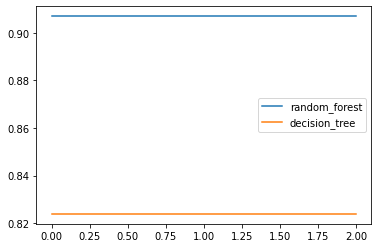

In [ ]:
cv_dict = {    
            'random_forest': rf_cv_scores,
            'decision_tree': dt_cv_scores,
          }

df = pd.DataFrame.from_dict(cv_dict)
df.plot()

Random Forest가 더 뛰어남을 알 수 있다.

In [ ]:
import numpy as np
# 두 모델의 평균 정확도 측정
print(f'Decision Tree accuracy: {np.mean(______)}')
print(f'Random Forest accuracy: {np.mean(______)}')

Decision Tree accuracy: 0.8238567071055268
Random Forest accuracy: 0.9069660863121257


#RandomForest와 ExtraTree 비교

In [ ]:
#데이터 준비
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
# Random_state = 42
X_train, X_test, y_train, y_test = ____________

In [ ]:
# Random Forest
# n_estimators = 500, max_leaf_nodes = 16, random_state = 42
# n_jobs 설정은 안 하셔도 되지만, 뒤에 사용자 행동 인식 데이터 사용할 때는 -1로 설정하는 걸 추천드립니다,, 
rnd_clf = _______________
______________   # 모델 학습
y_pred_rf = __________ # test 데이터에 대한 예측값

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

#엑스트라 트리, 하이퍼파라미터는 Random Forest와 똑같이
extra_clf = ____________
________   # 모델 학습
y_pred_ext = ________ # test 데이터에 대한 예측값

In [ ]:
from sklearn.metrics import accuracy_score

acc_rnd = ________ # 실제값과 예측값에 대한 랜덤 포레스트 정확도
acc_extra = __________ # 실제값과 예측값에 대한 엑스트라 트리 정확도
print('Random Forest :', acc_rnd)
print('Extra Tree :', acc_extra)

Random Forest : 0.912
Extra Tree : 0.912


##Scikit-Learn의 GradientBoostingRegressor를 이용

In [ ]:
#데이터 생성
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# max_depth = 2, n_estimators = 3, learning_rate = 1, random_state = 42
gbrt = _______
_____ # 모형 학습

GradientBoostingRegressor(learning_rate=1, max_depth=2, n_estimators=3,
                          random_state=42)

In [ ]:
X_new = np.array([[0.8]])  # new data

In [ ]:
print('y_pred :', ________) # new data에 대한 모형의 예측값

y_pred : [0.75026781]


아래의 예제는 학습시킬 모델의 개수(n_estimator)를 3개와 200개로 했을 때의 차이를 나타낸 것이다.

In [ ]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=1, random_state=42)
gbrt_slow.fit(X, y)
print('y_pred :', gbrt_slow.predict(X_new))

y_pred : [0.75026781]


예측값은 똑같은 것을 확인할 수 있다.

##GradientBoosting이 적용되는 것을 그림으로 표현해보자

예측값 그려주는 함수 정의

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

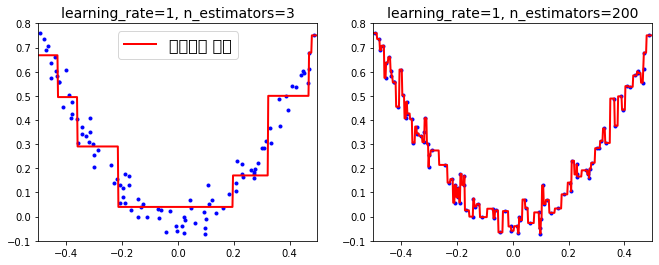

In [ ]:
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="앙상블의 예측")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

##n_estimators = 200일 때 데이터에 더 근접하게 적합됨을 알 수 있다. 따라서 연산 속도가 느려진다.

# XGBoost - 사용자 행동 인식 데이터

In [ ]:
# 사이킷런 래퍼 XGboost
from xgboost import XGBClassifier

In [ ]:
# 훈련 데이터 셋을 훈련과 검증 셋으로 나눕니다.
X_train, X_test, y_train, y_test = ________ # 위의 사용자 행동 인식 데이터 불러오는 함수 이용

# 학습 데이터를 다시 새로운 학습과 검증 데이터로 분리합니다.
# test_size = 0.2, random_state = 0
X_train, X_val, y_train, y_val = ________

In [ ]:
evals = [(X_val, y_val)] # evals에 검증 셋을 넣습니다.

#n_estimators = 100으로. 더 늘리면 시간 너무 오래 걸림
# learning_rate = 0.1, objective = 'multi:softmax' (why? multi-class 문제이므로)
# num_class = 6 (why? 종속변수 label이 6개이므로)
# max_depth = 3, random_state = 0
# n_jobs = -1 강추
xgb_wrapper = ________

# 모형 학습. eval_set = evals, eval_metric = 'mlogloss' (why? multi-class 문제라 'logloss'는 사용 불가)
# verbose = True
_________

# 테스트 데이터에 대한 예측값
w_preds = ________

[0]	validation_0-mlogloss:1.56475
[1]	validation_0-mlogloss:1.39171
[2]	validation_0-mlogloss:1.25065
[3]	validation_0-mlogloss:1.12957
[4]	validation_0-mlogloss:1.02754
[5]	validation_0-mlogloss:0.939304
[6]	validation_0-mlogloss:0.862731
[7]	validation_0-mlogloss:0.79352
[8]	validation_0-mlogloss:0.73332
[9]	validation_0-mlogloss:0.678792
[10]	validation_0-mlogloss:0.63003
[11]	validation_0-mlogloss:0.587225
[12]	validation_0-mlogloss:0.547352
[13]	validation_0-mlogloss:0.511273
[14]	validation_0-mlogloss:0.478886
[15]	validation_0-mlogloss:0.448629
[16]	validation_0-mlogloss:0.421753
[17]	validation_0-mlogloss:0.396974
[18]	validation_0-mlogloss:0.373898
[19]	validation_0-mlogloss:0.353054
[20]	validation_0-mlogloss:0.334434
[21]	validation_0-mlogloss:0.317355
[22]	validation_0-mlogloss:0.301113
[23]	validation_0-mlogloss:0.286375
[24]	validation_0-mlogloss:0.272835
[25]	validation_0-mlogloss:0.25993
[26]	validation_0-mlogloss:0.247088
[27]	validation_0-mlogloss:0.236556
[28]	valida

In [ ]:
# 평가 지표 출력해보자
# precision, recall, f1-score, support, accuracy가 한 번에 나오도록
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
# 위의 sklearn.metrics 사이트 참조
from sklearn.metrics import _________

print(________________) # 실제갑과 예측값을 이용

              precision    recall  f1-score   support

           1       0.93      0.99      0.96       496
           2       0.92      0.93      0.92       471
           3       0.98      0.90      0.94       420
           4       0.93      0.86      0.89       491
           5       0.88      0.94      0.91       532
           6       1.00      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



평가 지표가 매우 좋네요!

XGB Regression은 밑의 링크를 참조하세요!
https://machinelearningmastery.com/xgboost-for-regression/

#LGBM - 사용자 행동 인식 데이터

In [ ]:
from lightgbm import LGBMClassifier

# n_estimators = 100, learning_rate = 0.05, objective = 'multiclass', num_class = 6
lgbm_wrapper = ___________

evals = [(X_val, y_val)]
# 모형 학습, eval_set = evals, verbose = True
_________
l_preds = _________ # 테스트 데이터에 대한 예측값

[1]	valid_0's multi_logloss: 1.65355
[2]	valid_0's multi_logloss: 1.54333
[3]	valid_0's multi_logloss: 1.44534
[4]	valid_0's multi_logloss: 1.35807
[5]	valid_0's multi_logloss: 1.27954
[6]	valid_0's multi_logloss: 1.20759
[7]	valid_0's multi_logloss: 1.14212
[8]	valid_0's multi_logloss: 1.08099
[9]	valid_0's multi_logloss: 1.02475
[10]	valid_0's multi_logloss: 0.972712
[11]	valid_0's multi_logloss: 0.924026
[12]	valid_0's multi_logloss: 0.878711
[13]	valid_0's multi_logloss: 0.836225
[14]	valid_0's multi_logloss: 0.796585
[15]	valid_0's multi_logloss: 0.759761
[16]	valid_0's multi_logloss: 0.725224
[17]	valid_0's multi_logloss: 0.692739
[18]	valid_0's multi_logloss: 0.661734
[19]	valid_0's multi_logloss: 0.63289
[20]	valid_0's multi_logloss: 0.604954
[21]	valid_0's multi_logloss: 0.578661
[22]	valid_0's multi_logloss: 0.553534
[23]	valid_0's multi_logloss: 0.530261
[24]	valid_0's multi_logloss: 0.507886
[25]	valid_0's multi_logloss: 0.486787
[26]	valid_0's multi_logloss: 0.467246
[27]	

In [ ]:
# 평가 지표 출력해보자
# precision, recall, f1-score, support, accuracy가 한 번에 나오도록
from sklearn.metrics import ___________

print(________) # 실제값과 예측값 이용

              precision    recall  f1-score   support

           1       0.90      0.96      0.93       496
           2       0.90      0.87      0.89       471
           3       0.95      0.90      0.92       420
           4       0.91      0.80      0.85       491
           5       0.84      0.93      0.88       532
           6       1.00      1.00      1.00       537

    accuracy                           0.91      2947
   macro avg       0.92      0.91      0.91      2947
weighted avg       0.92      0.91      0.91      2947



LGBM도 좋은 평가지표를 보이네요!

LGBM Regression은 밑의 링크를 참조하세요!
https://www.datatechnotes.com/2022/03/lightgbm-regression-example-in-python.html

# 감사합니다!